# SECTION 1: 
## Contour Detection

In [2]:
# contouR_DETECTION.PY
import cv2

def detect_and_draw_contours(image_path, output_path='contours_image.jpg', min_area=500):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            print(cv2.contourArea(cnt))
            cv2.drawContours(img, [cnt], -1, (0, 255, 0), 2)
    cv2.imwrite(output_path, img)

detect_and_draw_contours("image.jpg")

2206.5
10307.0
2758.5
3835.5
3229.5
2573.5
6095.5
3390.0
1442.5
4747.5
7297.0
1419.5
934.0
3807.0
1921.0
5376.0
5546.0


## Canny Limitations and Alternatives

Sensitivity of Noise and weak edges
Hyper parametric tuning to find best thresholds.


### Alternatives:
- Sobel Filter : Detects horizontal and vertical edges.
- Laplacian of Gaussian (LoG) – Second-order derivative based edge detection.

# Section 2:
## Deep Learing Model Architecture and Design

In [7]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [8]:
# 3. Define Custom CNN
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [9]:
# 2. Data Augmentation and Loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = trainset.classes


100%|█████████████████████████| 170498071/170498071 [03:09<00:00, 901243.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# 4. Set device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# 5. Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(trainloader):.4f} Accuracy: {100*correct/total:.2f}%")


Epoch [1/10] Loss: 1.6458 Accuracy: 39.02%
Epoch [2/10] Loss: 1.3808 Accuracy: 49.57%
Epoch [3/10] Loss: 1.2386 Accuracy: 55.43%
Epoch [4/10] Loss: 1.1608 Accuracy: 58.56%
Epoch [5/10] Loss: 1.0954 Accuracy: 61.15%
Epoch [6/10] Loss: 1.0470 Accuracy: 63.22%
Epoch [7/10] Loss: 1.0063 Accuracy: 64.71%
Epoch [8/10] Loss: 0.9645 Accuracy: 66.16%
Epoch [9/10] Loss: 0.9372 Accuracy: 67.20%
Epoch [10/10] Loss: 0.9153 Accuracy: 68.49%


In [13]:
# 6. Evaluate on Test Set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 75.13%


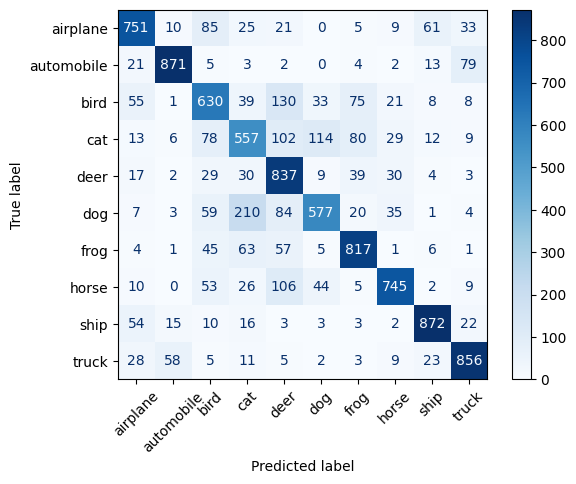

In [14]:
# 7. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


## why transfer learning is often used in computer vision tasks
- Training a new complete model from scratich is long and time consuming and computationally costly.
- Getting the Vast amount of data is more difficult,
- So we use pretrain model for its weights and fine tune based on our requirements which reduces computation and time, will converse faster than the model training from scratch.
  

In [15]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional block (layer4)
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the final fully connected layer to fit binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)  # Binary classification (2 classes)
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer (only trainable parameters)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()


/home/santhosh/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/santhosh/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Section 3: 
## Real-World Scenario & Optimization

### Flask API for Real-Time YOLOv5 Detection on Video

In [ ]:
from flask import Flask, request, send_file
import torch
import cv2
import numpy as np
import tempfile
import os

# Initialize Flask app
app = Flask(__name__)

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

@app.route('/detect_video', methods=['POST'])
def detect_video():
    if 'video' not in request.files:
        return 'No video file uploaded', 400

    video_file = request.files['video']
    
    # Save uploaded video temporarily
    temp_input = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
    temp_input.write(video_file.read())
    temp_input.close()

    # Open video
    cap = cv2.VideoCapture(temp_input.name)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4').name
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (frame.shape[1], frame.shape[0]))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Inference
        results = model(frame)
        detections = results.xyxy[0]  # Bounding boxes
        for *box, conf, cls in detections.cpu().numpy():
            x1, y1, x2, y2 = map(int, box)
            label = f'{model.names[int(cls)]} {conf:.2f}'
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)            

        out.write(frame)

    cap.release()
    out.release()

    # Send back processed video
    return send_file(output_path, mimetype='video/mp4', as_attachment=True, download_name='processed_video.mp4')

if __name__ == '__main__':
    app.run(debug=True)


## Edge Optimization

## Strategies:
- Quantization
- Pruning
- Knowledge distillation

### TensorFlow Lite Quantization Example:

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('model_v7.pt')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)
